# Introduction to Datamate

The notebook demonstrates datamate for storing and retrieving mockup measurements of locations, colors, and connectivity of brain cells.


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/Brainbow_%28Smith_2007%29.jpg/715px-Brainbow_%28Smith_2007%29.jpg" alt="drawing" style="width:50%" title="From Wikipedia: Mouse neurons labeled with fluorescent tags. Such “color coded” brain cells promise new solutions to formerly intractable problems with resolving closely packed neurons and tracing their axons and dendrites reliably over long distances. It seems unlikely that neural information processing will ever be understood without solving such problems and reconstructing circuits in far more detail that presently possible."/>

Image by Stephen J Smith, December 21, 2007: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2693015/

## `Directory` to interact with a hierachical filesystem

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from datamate import Directory, set_root_dir

%load_ext autoreload
%autoreload 2

In [2]:
# we set the root directory. this is where our journey on the hierarchical filesystem starts
root_dir = Path(".") / "data"
set_root_dir(root_dir)

# to erase data from earlier execution of this notebook
if root_dir.exists():
    import shutil
    shutil.rmtree(root_dir)

In [3]:
# we create a first Directory instance pointing to a directory relative to root_dir.
cell_measurements = Directory()
cell_measurements

Directory_0000/
    (path does not exist)

Taking mockup cell measurements of identity, x- and y-coordinates and colors.

In [4]:
# we can store data by setting the Directory's attributes.
n_cells = 100
cell_measurements.cell_id = np.arange(n_cells)
cell_measurements.x = np.random.normal(0, 1, size=n_cells)
cell_measurements.y = np.random.normal(0, 1, size=n_cells)
cell_measurements.colors = np.random.rand(n_cells, 3)

In [5]:
# explore files and directories
cell_measurements

Directory_0000/ - Last modified: May 01, 2023 00:32:49
├── _meta.yaml
├── cell_id.h5
├── colors.h5
├── x.h5
└── y.h5

displaying: 1 directory, 5 files

Text(0.5, 1.0, 'Locations and colors of 100 cells')

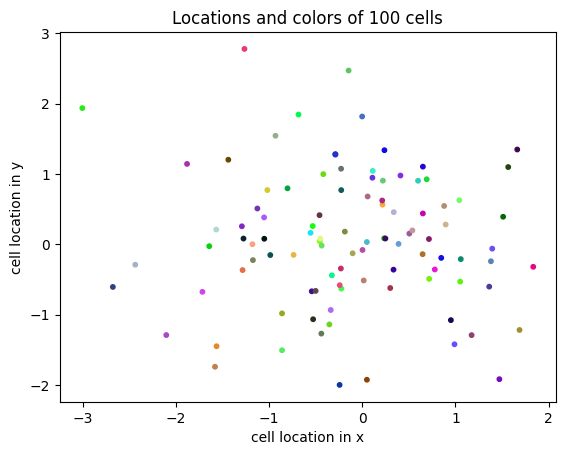

In [6]:
# and access data
plt.scatter(cell_measurements.x, cell_measurements.y, c=cell_measurements.colors, s=10)
plt.xlabel("cell location in x")
plt.ylabel("cell location in y")
plt.title(f"Locations and colors of {n_cells} cells")

Text(0.5, 1.0, 'Locations and colors of 50 cells')

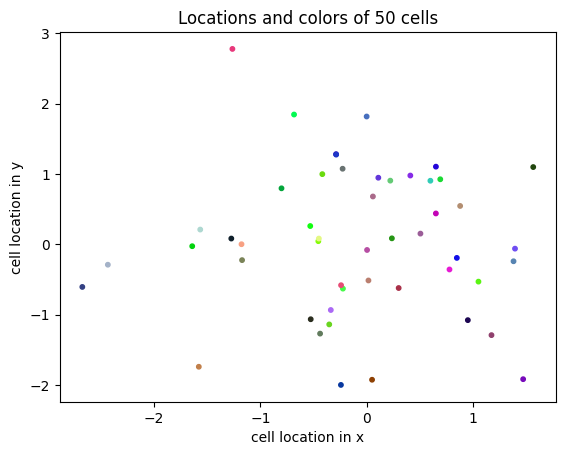

In [7]:
# we can index the h5-arrays from disk without fully loading them to memory for flexible memory usage
start_cell_id = 0
end_cell_id = 50
plt.scatter(
    cell_measurements.x[start_cell_id:end_cell_id],
    cell_measurements.y[start_cell_id:end_cell_id],
    c=cell_measurements.colors[start_cell_id:end_cell_id],
    s=10,
)
plt.xlabel("cell location in x")
plt.ylabel("cell location in y")
plt.title(f"Locations and colors of {end_cell_id - start_cell_id} cells")

In [8]:
# we can use the directory name point to the same directory again
cell_measurements = Directory("Directory_0000")

In [9]:
cell_measurements

Directory_0000/ - Last modified: May 01, 2023 00:32:49
├── _meta.yaml
├── cell_id.h5
├── colors.h5
├── x.h5
└── y.h5

displaying: 1 directory, 5 files

In [10]:
# we can navigate upwards on the filesystem hierarchy
cell_measurements.parent

data/ - Last modified: May 01, 2023 00:32:49
└── Directory_0000/
    ├── _meta.yaml
    ├── cell_id.h5
    ├── colors.h5
    ├── x.h5
    └── y.h5

displaying: 2 directories, 5 files

In [11]:
# we can navigate upwards multiple times on the filesystem hierarchy
cell_measurements.parent.parent

examples/ - Last modified: May 01, 2023 00:32:49
├── .ipynb_checkpoints/
│   ├── 01. Introduction to Datamate-checkpoint.ipynb
│   ├── Untitled-checkpoint.ipynb
│   └── another thread-checkpoint.ipynb
├── 01. Introduction to Datamate.ipynb
├── Test_0000/
│   └── _meta.yaml
├── Test_0001/
│   └── _meta.yaml
├── Untitled.ipynb
├── another thread.ipynb
├── data/
│   └── Directory_0000/
│       ├── _meta.yaml
│       ├── cell_id.h5
│       ├── colors.h5
│       ├── x.h5
│       └── y.h5
└── experiments_config/
    ├── _meta.yaml
    ├── measurements 1.h5
    └── measurements 2.h5

displaying: 7 directories, 16 files

In [12]:
# we can create a pointer to a child Directory on the hiearchical filesystem 
# (as long as no file/attribute with this already name exists)
cell_measurements.connections

connections/
    (path does not exist)

We measure a mockup connectivity matrix between the identified cells.

Text(0.5, 1.0, 'connectivity matrix')

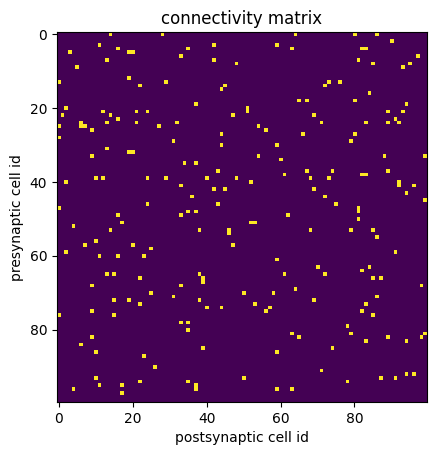

In [13]:
# we measure the following connectivity matrix
connectivity_matrix = np.random.randn(n_cells, n_cells) > 2
plt.imshow(connectivity_matrix)
plt.xlabel("postsynaptic cell id")
plt.ylabel("presynaptic cell id")
plt.title("connectivity matrix")

In [14]:
# we store the connectivity as graph (i.e. edges) because its sparse
post_cell_id, pre_cell_id = np.where(connectivity_matrix)
cell_measurements.connections.pre_cell_id = pre_cell_id
cell_measurements.connections.post_cell_id = post_cell_id

In [15]:
# the connections are now stored in our directory
cell_measurements

Directory_0000/ - Last modified: May 01, 2023 00:32:50
├── _meta.yaml
├── cell_id.h5
├── colors.h5
├── connections/
│   ├── _meta.yaml
│   ├── post_cell_id.h5
│   └── pre_cell_id.h5
├── x.h5
└── y.h5

displaying: 2 directories, 8 files

In [16]:
# to access them later from
cell_measurements.connections

connections/ - Last modified: May 01, 2023 00:32:50
├── _meta.yaml
├── post_cell_id.h5
└── pre_cell_id.h5

displaying: 1 directory, 3 files

In [17]:
# with attribute-style access
cell_measurements.connections.pre_cell_id

<HDF5 dataset "data": shape (228,), type "<i8">

In [18]:
# or composing strings following the pathlib syntax for your preference
cell_measurements / "connections/pre_cell_id"

<HDF5 dataset "data": shape (228,), type "<i8">

## Configure `Directory`s to compile their contents in explainable ways

We wrap up the code above into a coherent object that can be configured and compiled to populated `Directory`s.

In [19]:
from time import sleep
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from datamate import Directory, root

data_dir = Path(".")/ "data"

@root(data_dir)
class CellMeasurements(Directory):
    
    def __init__(self, n_cells=100, seed=0):
        print("Loading connectome ...")
        sleep(5)
        np.random.seed(seed)

        # store cell attributes
        self.cell_id = np.arange(n_cells)
        self.x = np.random.normal(0, 1, size=n_cells)
        self.y = np.random.normal(0, 1, size=n_cells)
        self.colors = np.random.rand(n_cells, 3)

        # store connectivity attributes
        connectivity_matrix = np.random.randn(n_cells, n_cells)
        pre_cell_id, post_cell_id = np.where(connectivity_matrix > 2)
        self.connections.pre_cell_id = pre_cell_id
        self.connections.post_cell_id = post_cell_id
        print("Stored connectome!")

In [20]:
# we init a Directory pointer of type 'CellMeasurements' (in the root directory).
# it's __init__ is called if a directory of this type and config does not yet exist
cell_measurements = CellMeasurements()

Loading connectome ...
Stored connectome!


In [21]:
# contents written by __init__
cell_measurements

CellMeasurements_0000/ - Last modified: May 01, 2023 00:32:56
├── _meta.yaml
├── cell_id.h5
├── colors.h5
├── connections/
│   ├── _meta.yaml
│   ├── post_cell_id.h5
│   └── pre_cell_id.h5
├── x.h5
└── y.h5

displaying: 2 directories, 8 files

In [22]:
# config written by __init__
cell_measurements.meta

Namespace(
  config = Namespace(type='CellMeasurements', n_cells=100, seed=0),
  status = 'done'
)

In [23]:
# changing the config, e.g. the seed, we get a second directory of the same type (but with different data)
cell_measurements_2 = CellMeasurements(n_cells=100, seed=42)

Loading connectome ...
Stored connectome!


In [24]:
cell_measurements_2

CellMeasurements_0001/ - Last modified: May 01, 2023 00:33:01
├── _meta.yaml
├── cell_id.h5
├── colors.h5
├── connections/
│   ├── _meta.yaml
│   ├── post_cell_id.h5
│   └── pre_cell_id.h5
├── x.h5
└── y.h5

displaying: 2 directories, 8 files

In [25]:
cell_measurements_2.meta

Namespace(
  config = Namespace(type='CellMeasurements', n_cells=100, seed=42),
  status = 'done'
)

### Restart kernel and come back later without recomputing

In [26]:
from time import sleep
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from datamate import Directory, root

data_dir = Path(".")/ "data"

@root(data_dir)
class CellMeasurements(Directory):
    
    def __init__(self, n_cells=100, seed=0):
        print("Loading connectome ...")
        sleep(5)
        np.random.seed(seed)

        # store cell attributes
        self.cell_id = np.arange(n_cells)
        self.x = np.random.normal(0, 1, size=n_cells)
        self.y = np.random.normal(0, 1, size=n_cells)
        self.colors = np.random.rand(n_cells, 3)

        # store connectivity attributes
        connectivity_matrix = np.random.randn(n_cells, n_cells)
        pre_cell_id, post_cell_id = np.where(connectivity_matrix > 2)
        self.connections.pre_cell_id = pre_cell_id
        self.connections.post_cell_id = post_cell_id
        print("Stored connectome!")

In [27]:
# fast init because points to the directories with the same type and configuration
cell_measurements = CellMeasurements(n_cells=100, seed=0)
cell_measurements_2 = CellMeasurements(n_cells=100, seed=42)

In [28]:
cell_measurements.config

Namespace(type='CellMeasurements', n_cells=100, seed=0)

In [29]:
cell_measurements_2.config

Namespace(type='CellMeasurements', n_cells=100, seed=42)

### Use pandas for dataframe wrangling

Load the h5 data to a pandas dataframe for further processing.

In [30]:
cells = cell_measurements.to_df()
connections = cell_measurements.connections.to_df()

In [31]:
cells

,cell_id,x,y,colors
0,0,1.764052,1.883151,"[0.961936378547229, 0.29214752679254885, 0.240..."
1,1,0.400157,-1.347759,"[0.10029394226549782, 0.016429629591474204, 0...."
2,2,0.978738,-1.270485,"[0.66991654659091, 0.7851529120231378, 0.28173..."
3,3,2.240893,0.969397,"[0.5864101661863267, 0.06395526612098112, 0.48..."
4,4,1.867558,-1.173123,"[0.9774951397444468, 0.8765052453165908, 0.338..."
...,...,...,...,...
95,95,0.706573,-0.171546,"[0.5887396099702882, 0.9627703198402424, 0.016..."
96,96,0.010500,0.771791,"[0.6964824307014501, 0.8136786497018634, 0.509..."
97,97,1.785870,0.823504,"[0.33396486959680916, 0.7908401632274049, 0.09..."
98,98,0.126912,2.163236,"[0.44203563772992527, 0.5199523745708382, 0.69..."


In [32]:
connections

,post_cell_id,pre_cell_id
0,23,0
1,33,0
2,62,0
3,28,1
4,54,2
...,...,...
206,8,97
207,35,97
208,9,98
209,81,98


Load the meta data into a pandas dataframe.

In [33]:
cell_measurements.meta.to_df(name='measurements 1')

,measurements 1
status,done
config.type,CellMeasurements
config.n_cells,100
config.seed,0


In [34]:
cell_measurements_2.meta.to_df(name='measurements 2')

,measurements 2
status,done
config.type,CellMeasurements
config.n_cells,100
config.seed,42


E.g. to tabularize experiment configurations.

In [35]:
configs = cell_measurements.meta.to_df(name='measurements 1').join(cell_measurements_2.meta.to_df(name='measurements 2'))
configs

,measurements 1,measurements 2
status,done,done
config.type,CellMeasurements,CellMeasurements
config.n_cells,100,100
config.seed,0,42


Or vice versa, to create a directory from a pandas DataFrame (note, must provide [h5py compatible type information](https://docs.h5py.org/en/stable/faq.html)):

In [36]:
configs

,measurements 1,measurements 2
status,done,done
config.type,CellMeasurements,CellMeasurements
config.n_cells,100,100
config.seed,0,42


In [37]:
dtypes = {"measurements 1": 'S50', "measurements 2": 'S50'}

In [38]:
directory = Directory.from_df(configs, dtypes, "experiments_config")

In [39]:
directory

experiments_config/ - Last modified: May 01, 2023 00:33:01
├── _meta.yaml
├── measurements 1.h5
└── measurements 2.h5

displaying: 1 directory, 3 files

In [40]:
directory.to_df(dtypes={"measurements 1": str, "measurements 2": str})

,measurements 2,measurements 1
0,done,done
1,CellMeasurements,CellMeasurements
2,100,100
3,42,0


### Example: visualize the graph

In [41]:
def visualize_measurements(cell_measurements):
    try:
        import networkx as nx
    except ModuleNotFoundError as e:
        print(e, ", install networkx to visualize the cell graph structure.")
        _input = input("install now? yes/no")
        if _input == "yes":
            import sys
            !{sys.executable} -m pip install networkx[default]
            import networkx as nx
        else:
            return
        
    cells = cell_measurements.to_df()
    connections = cell_measurements.connections.to_df()
        
    G = nx.Graph()
    G.add_nodes_from(cells.cell_id)
    G.add_edges_from(connections.values)
    pos = dict(zip(cells["cell_id"].values, cells[["x", "y"]].values))

    options = {
        "font_size": 4,
        "node_size": 10,
        "node_color": cell_measurements.colors[:],
        "edgecolors": "0.5",
        "linewidths": 0.25,
        "width": 0.25,
    }
    nx.draw_networkx(G, pos, **options)

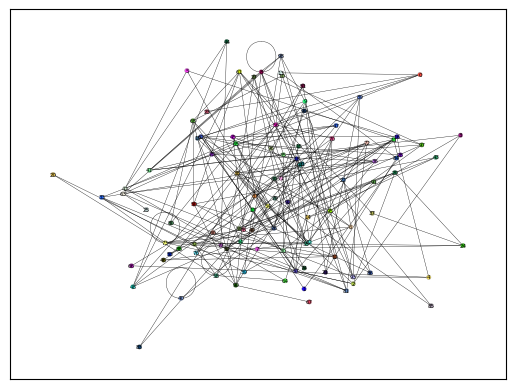

In [42]:
visualize_measurements(cell_measurements)

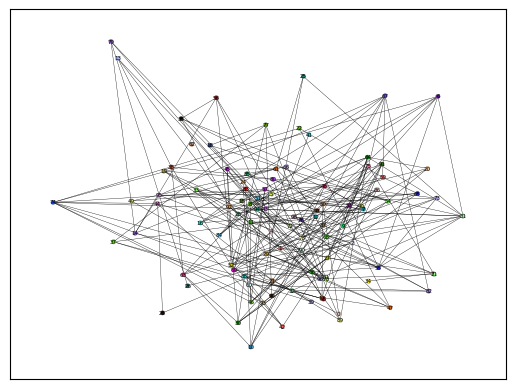

In [43]:
visualize_measurements(cell_measurements_2)

### View diffs of configs to explain Directory contents

In [44]:
cell_measurements.meta.diff(cell_measurements_2.meta)

Namespace(self=['≠config.seed: 0'], other=['≠config.seed: 42'])

## Set verbosity levels to navigate better through the filesystem

In [45]:
from datamate import Directory, set_verbosity_level

data_dir = Path(".")/ "data"

In [46]:
# default: all subdirectories and files are displayed
set_verbosity_level(2)
Directory(data_dir)

data/ - Last modified: May 01, 2023 00:33:01
├── CellMeasurements_0000/
│   ├── _meta.yaml
│   ├── cell_id.h5
│   ├── colors.h5
│   ├── connections/
│   │   ├── _meta.yaml
│   │   ├── post_cell_id.h5
│   │   └── pre_cell_id.h5
│   ├── x.h5
│   └── y.h5
├── CellMeasurements_0001/
│   ├── _meta.yaml
│   ├── cell_id.h5
│   ├── colors.h5
│   ├── connections/
│   │   ├── _meta.yaml
│   │   ├── post_cell_id.h5
│   │   └── pre_cell_id.h5
│   ├── x.h5
│   └── y.h5
├── Directory_0000/
│   ├── _meta.yaml
│   ├── cell_id.h5
│   ├── colors.h5
│   ├── connections/
│   │   ├── _meta.yaml
│   │   ├── post_cell_id.h5
│   │   └── pre_cell_id.h5
│   ├── x.h5
│   └── y.h5
└── experiments_config/
    ├── _meta.yaml
    ├── measurements 1.h5
    └── measurements 2.h5

displaying: 8 directories, 27 files

In [47]:
# maximally 2 levels of the hierarchy and 25 lines are displayed
set_verbosity_level(1)
Directory(data_dir)

data/ - Last modified: May 01, 2023 00:33:01
├── CellMeasurements_0000/
│   ├── _meta.yaml
│   ├── cell_id.h5
│   ├── colors.h5
│   ├── connections/
│   │   ...
│   ├── x.h5
│   └── y.h5
├── CellMeasurements_0001/
│   ├── _meta.yaml
│   ├── cell_id.h5
│   ├── colors.h5
│   ├── connections/
│   │   ...
│   ├── x.h5
│   └── y.h5
├── Directory_0000/
│   ├── _meta.yaml
│   ├── cell_id.h5
│   ├── colors.h5
│   ├── connections/
│   │   ...
│   ├── x.h5
│   └── y.h5
└── experiments_config/
... length_limit, 25, reached,
displaying: 8 directories, 15 files, 2 levels.

In [48]:
# simply the referenced folder and last modified date
set_verbosity_level(0)
Directory(data_dir)

data/ - Last modified: May 01, 2023 00:33:01

In [49]:
set_verbosity_level(2)

## Simultaneously write and read to monitor the data

1. Start the mockup training loop by running the cells below.
2. Start and run the jupyter notebook `another thread.ipynb` to see simultaneous write and read in action.

In [50]:
from tqdm.auto import tqdm
from time import sleep
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from datamate import Directory, root

data_dir = Path(".")/ "data"

@root(data_dir)
class NetworkDir(Directory):
    
    class Config:
        tau: float = 200.
        sigma: float = 0.1
    
    def train(self):
        del self.loss
        for i in tqdm(range(10000), desc="Training"):
            self.extend("loss", [np.exp(-i / self.config.tau) + np.random.rand() * self.config.sigma])
            sleep(0.25)

In [51]:
tnn = NetworkDir()
tnn

NetworkDir_0000/
    (path does not exist)

In [52]:
tnn.train()

KeyboardInterrupt: 

In [53]:
tnn

NetworkDir_0000/ - Last modified: May 01, 2023 00:33:03
├── _meta.yaml
└── loss.h5

displaying: 1 directory, 2 files